# Hawaii Climate Analysis with SQLAlchemy

In [147]:
# load dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

In [148]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

## Reflect Tables into SQLAlchemy ORM

In [149]:
# create engine to hawaii.sqlite
database_path = 'Resources/hawaii.sqlite'
engine = create_engine(f'sqlite:///{database_path}')
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [150]:
# reflect an existing database into a new model
Base = automap_base()

#reflect the tables
Base.prepare(autoload_with=engine)
Base

sqlalchemy.ext.automap.Base

In [151]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [152]:
# save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [153]:
# create a session (link) from Python to the SQLite DB
session = Session(bind=engine)
session

## Exploratory Precipitation Analysis

In [154]:
# find the most recent date in the data set
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent

'2017-08-23'

In [155]:
# design a query to retrieve the last 12 months of precipitation data and plot the results
# starting from the most recent data point in the database

from dateutil.relativedelta import relativedelta 

# calculate the date one year from the last date in data set
prev_year = (dt.datetime.strptime(most_recent, '%Y-%m-%d') - relativedelta(years=1)).strftime('%Y-%m-%d')
prev_year

'2016-08-23'

In [156]:
# perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prev_year).\
    order_by(Measurement.date).all()

In [157]:
# save the query results as a Pandas DataFrame
# explicitly set the column names
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [158]:
# sort the dataframe by date
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'])
prcp_df = prcp_df.sort_values(by='Date')

prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


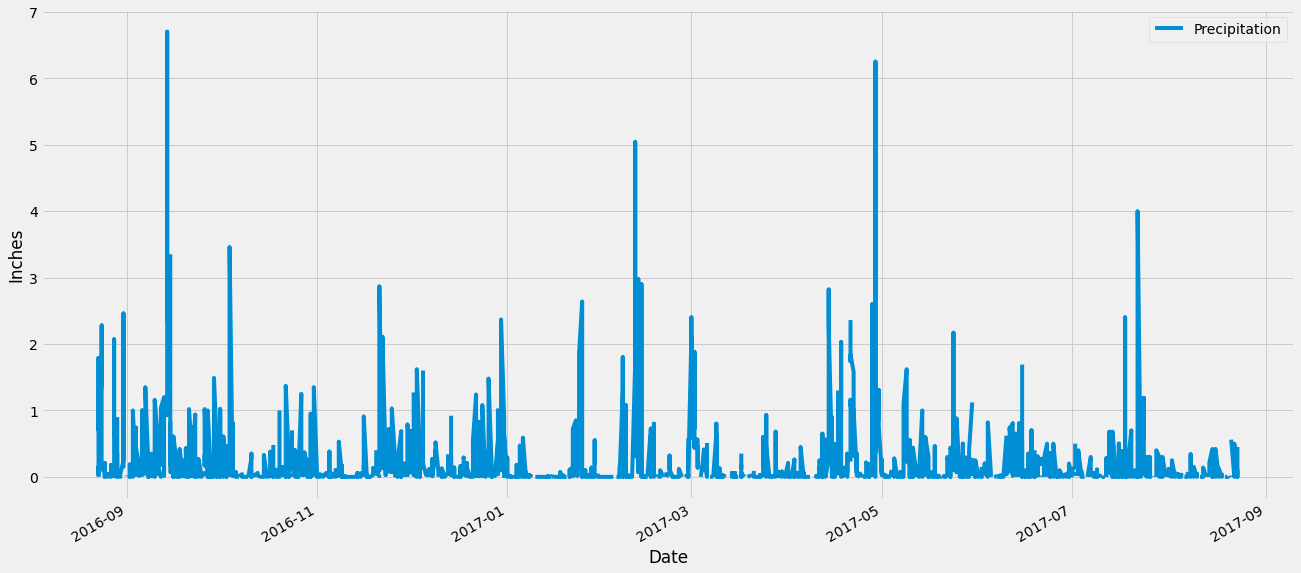

In [159]:
# use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='Date', y='Precipitation', figsize=(20, 10), ylabel='Inches')
plt.show()

In [160]:
# calculate summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

In [161]:
# design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.id)).all()[0][0]
station_count

9

In [162]:
# design a query to find the most active stations (i.e. which stations have the most rows?)
# list the stations and their counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [163]:
# log the most active station id from the previous query
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

# calculate the lowest, highest, and average temperature
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [164]:
# using the most active station id
# query the last 12 months of temperature observation data for this station
most_recent = session.query(Measurement.date).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date.desc()).first()[0]

most_recent

'2017-08-18'

In [165]:
# find the date for one year prior to last measurement for this station
starting_point = (dt.datetime.strptime(most_recent, '%Y-%m-%d') - relativedelta(years=1)).strftime('%Y-%m-%d')
starting_point

'2016-08-18'

In [171]:
temps_df = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= starting_point).all(), columns=['Date', 'Temperature'])

temps_df['Date'] = pd.to_datetime(temps_df['Date'])
temps_df = temps_df.sort_values(by='Date')

temps_df.head()

,Date,Temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


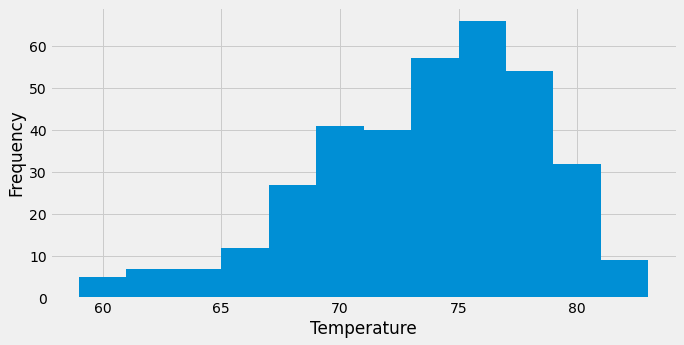

In [178]:
# plot the results as a histogram
temps_df['Temperature'].plot.hist(figsize=(10, 5), bins=12)
plt.xlabel('Temperature')
plt.show()

## Close Session

In [173]:
# close session
session.close()